In [1]:
import sys

sys.path.append("../")  # go to parent dir

%load_ext autoreload
%autoreload 2


from pathlib import Path
import numpy as np
from ddmtools.analysis import ddm
from matplotlib import pyplot as plt
from ddmtools.analysis import DDM
from ddmtools.image.frame import Framestack

project_path = (Path(".") / "..").resolve()
data_path = project_path / "data"
experiment_path = data_path / "2BD01_1__middle1"

In [2]:
CROP_SIZE = (256, 256)

stack = Framestack.from_folder(
    experiment_path,
    crop_target=CROP_SIZE,
)

ddm = DDM(
    stack=stack,
    framerate=1.0,
    micrometre_per_pixel=0.234,
    temperature=273.0 + 21.0,
    viscosity=0.9775e-3,
)
# patch framerate
ddm.framerate = len(ddm.stack) / 10.0

ddm.stack.load()

Text(0.5, 0.98, 'Frame 1 - Frame 2')

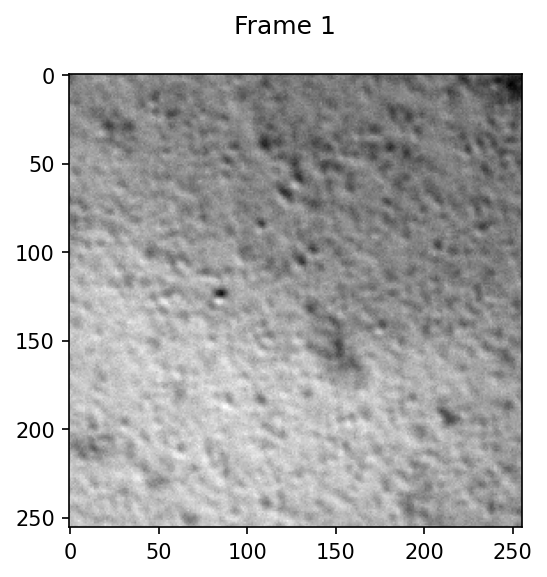

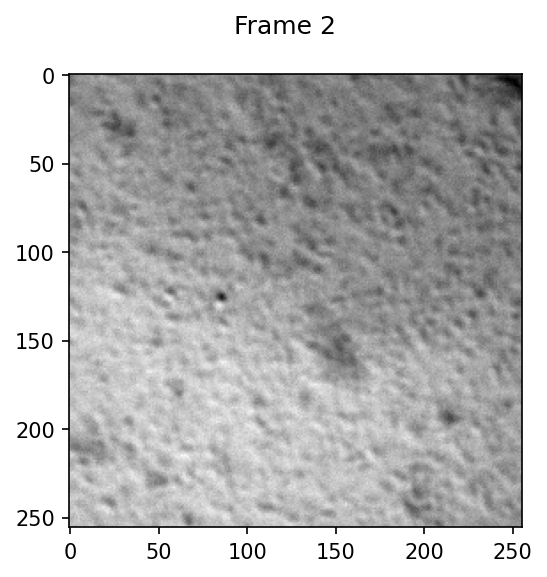

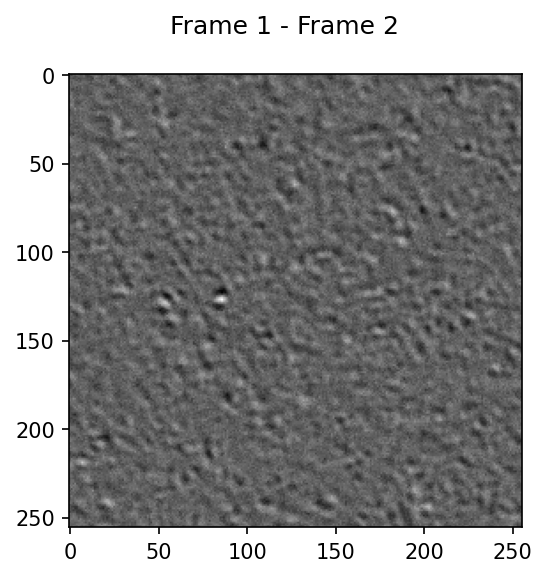

In [3]:
frame1 = ddm.stack[10]
frame2 = ddm.stack[20]

fig = plt.figure(dpi=150)
plt.imshow(frame1, plt.cm.gray)
fig.suptitle("Frame 1")

fig = plt.figure(dpi=150)
plt.imshow(frame2, plt.cm.gray)
fig.suptitle("Frame 2")

fig = plt.figure(dpi=150)
plt.imshow(frame1 - frame2, plt.cm.gray)
fig.suptitle("Frame 1 - Frame 2")

Text(0.5, 0.98, 'Differential Spectrum')

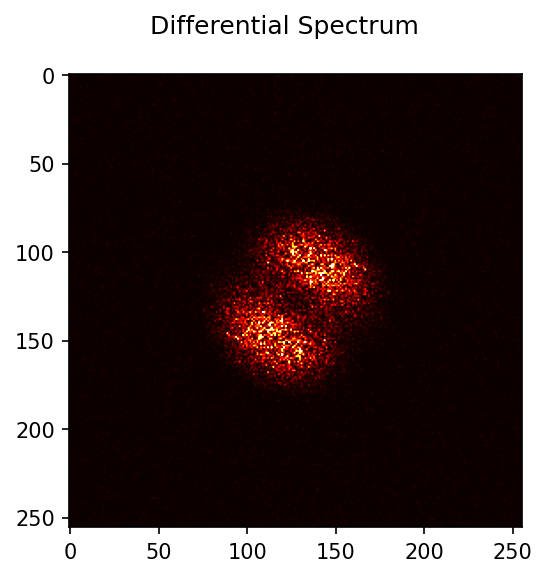

In [4]:
# Show a differential spectrum
diff = ddm.get_differential_spectrum(10, 20)
fig = ddm.plot_differential_spectrum(diff, 3)
fig.set_dpi(150)
fig.suptitle("Differential Spectrum")

Text(0.5, 0.98, 'Frame 1, Time averaged signal')

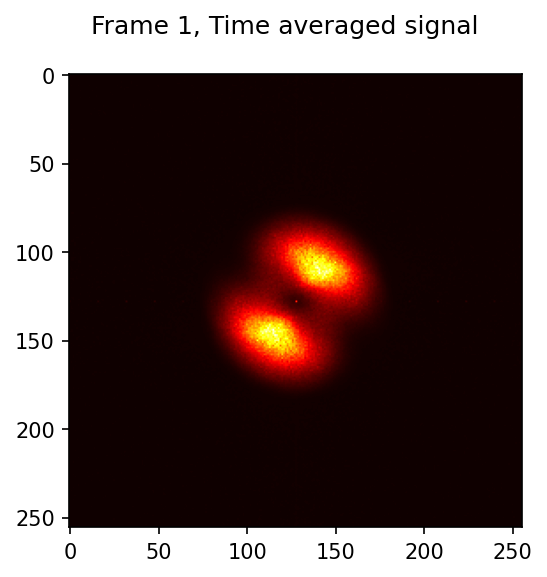

In [5]:
# Show time average
average = ddm.get_time_average(10, max_couples=300)

fig = ddm.plot_time_average(average, brightness=1.0)
fig.set_dpi(150)
fig.suptitle("Frame 1, Time averaged signal")

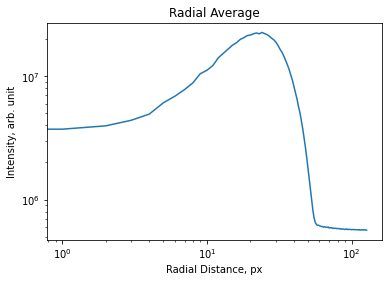

In [6]:
# Show radial average
# We can radially average since we expect isotropy

rad_average = ddm.get_radial_average(average)
fig = ddm.plot_radial_average(rad_average)
fig.set_dpi(150)

In [7]:
taus = ddm.get_log_spaced_taus(100)
# taus = np.array(range(len(ddm.stack) - 50))

times = ddm.taus_to_times(taus)
iqtaus = ddm.analyse(taus, max_couples=100)

  0%|          | 0/177 [00:00<?, ?it/s]

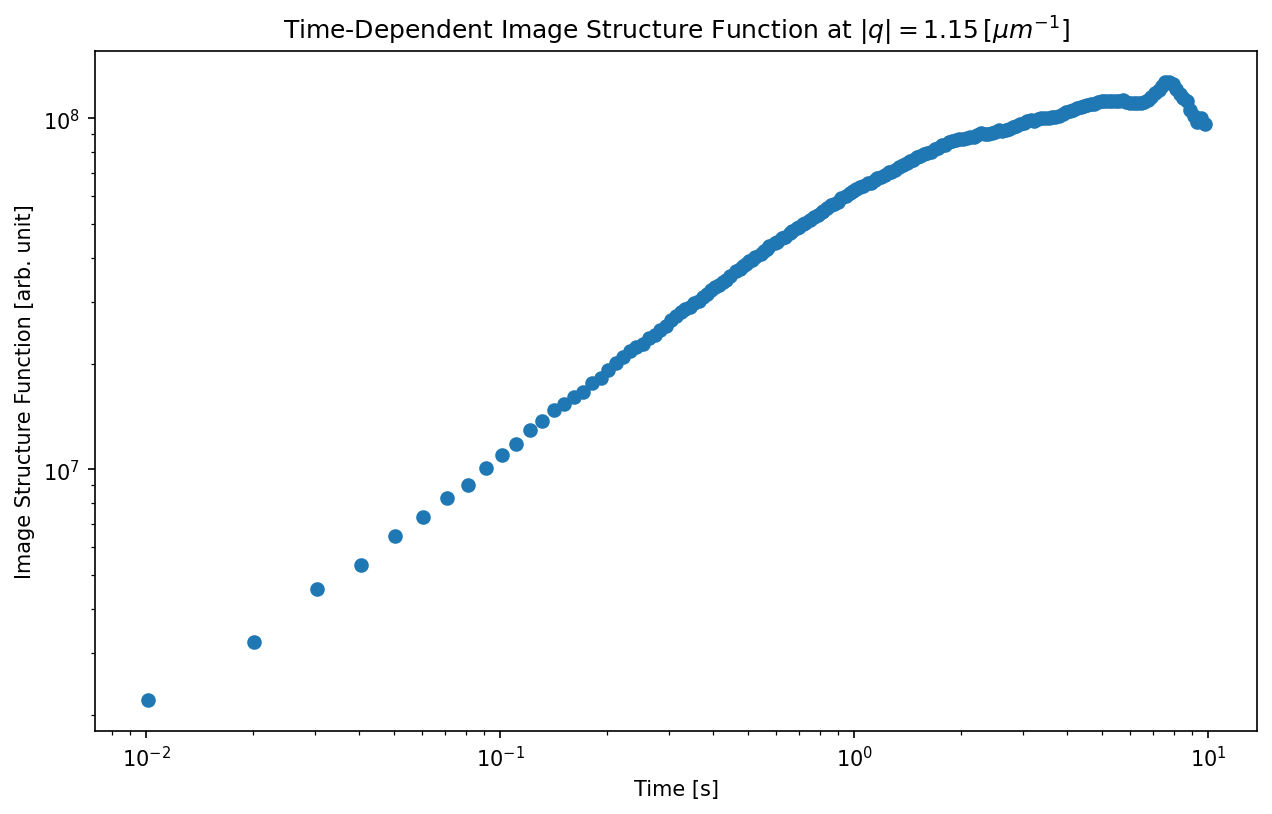

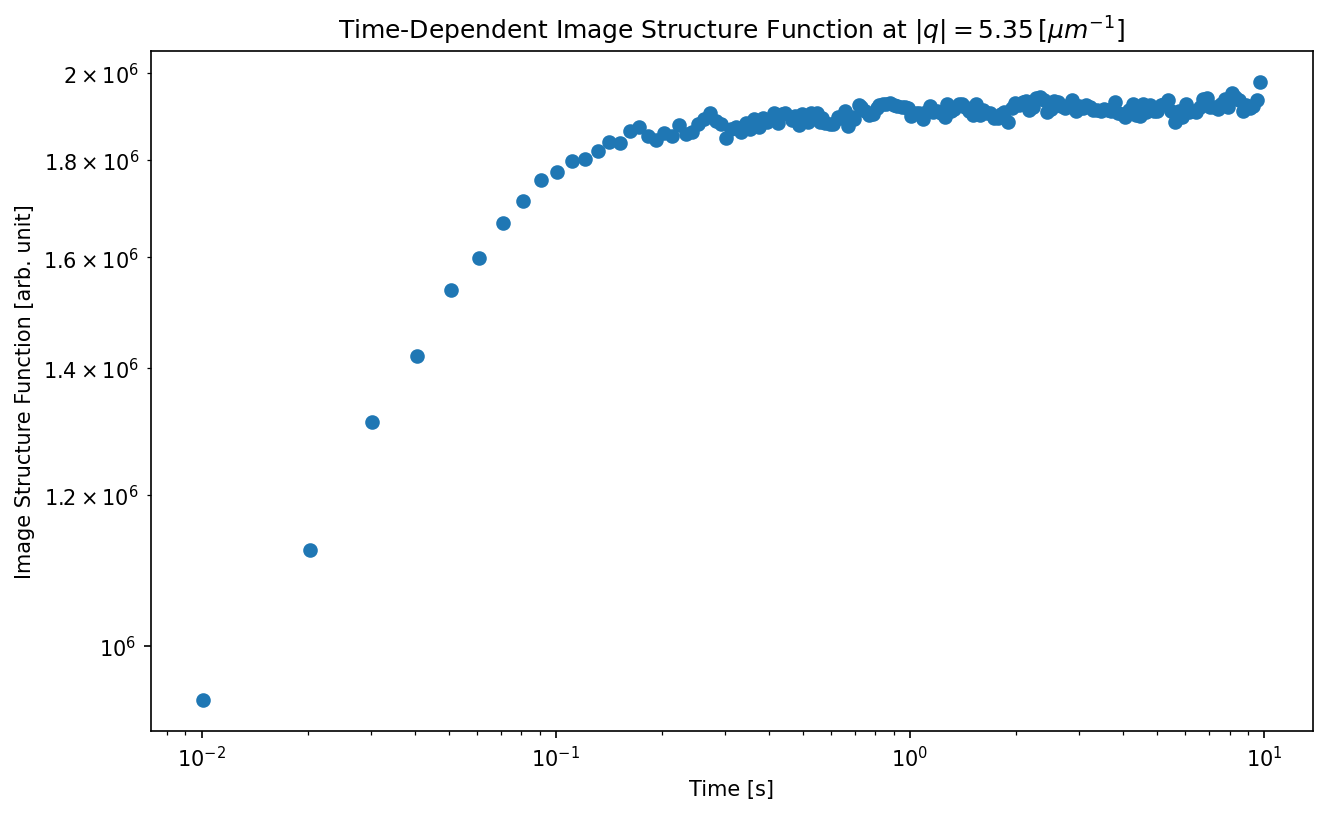

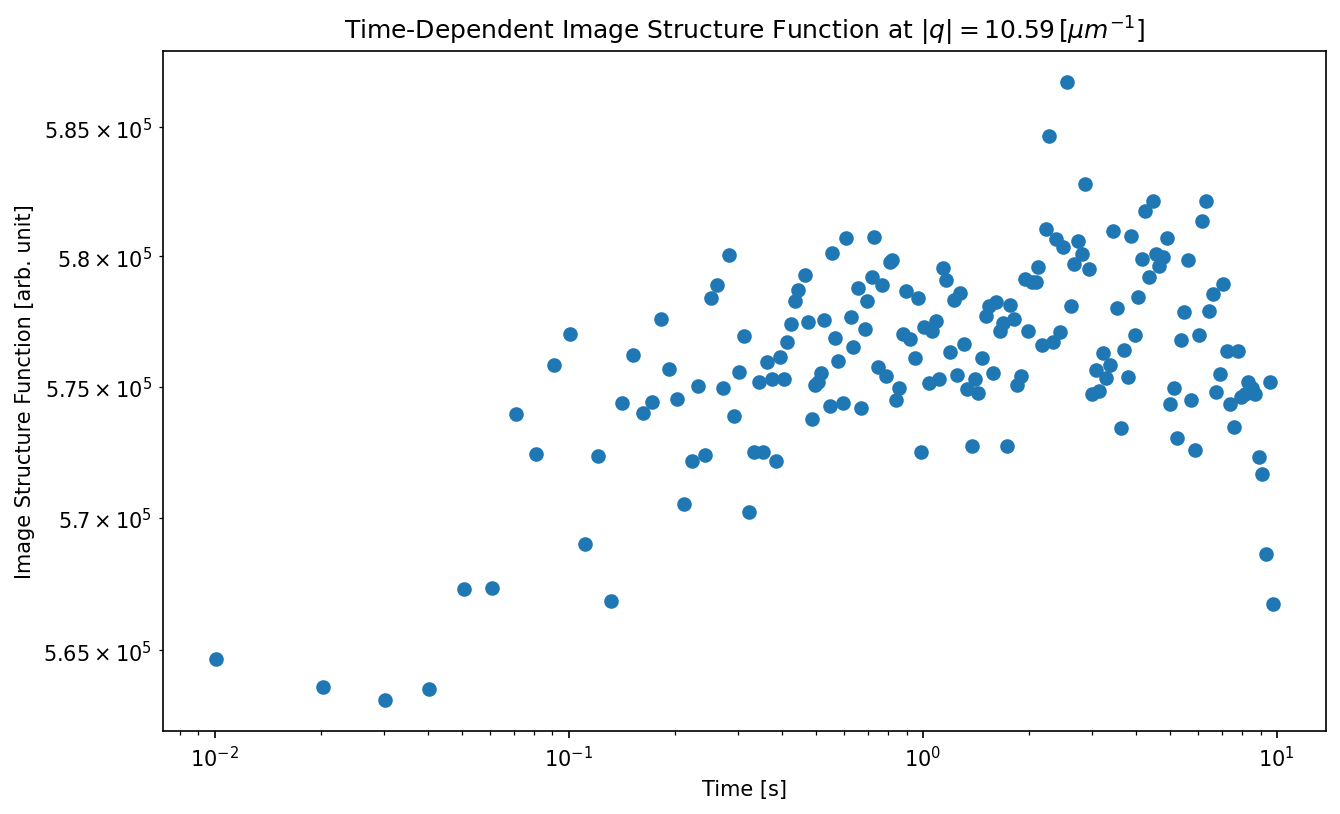

In [8]:
fig = ddm.plot_image_structure_function(10)
fig = ddm.plot_image_structure_function(50)
fig = ddm.plot_image_structure_function(100)

In [9]:
qs = ddm.iqtaus_to_qs()
print(len(times), len(qs))

177 128


In [10]:
dispersity_order = 2
min_result = ddm.fit_image_structure_functions_polydisperse(
    dispersity_order, method_sequence=["least_squares"], max_nfev=10000
)


print(f"Objective function evaluations: {min_result.minimizer_result.nfev}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Doing fit 1/1 using method `least_squares`...
Done.
Objective function evaluations: 23


In [11]:
min_result.minimizer_result  # Warning: very verbose

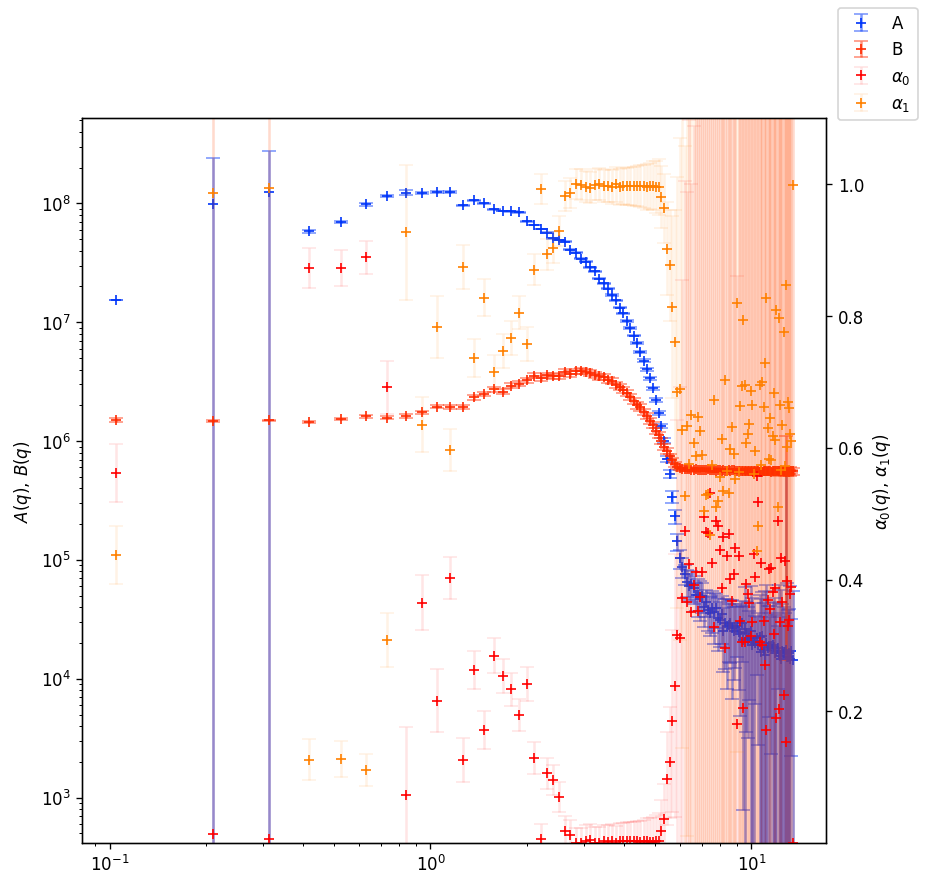

In [12]:
fig = min_result.plot_image_structure_function_params()

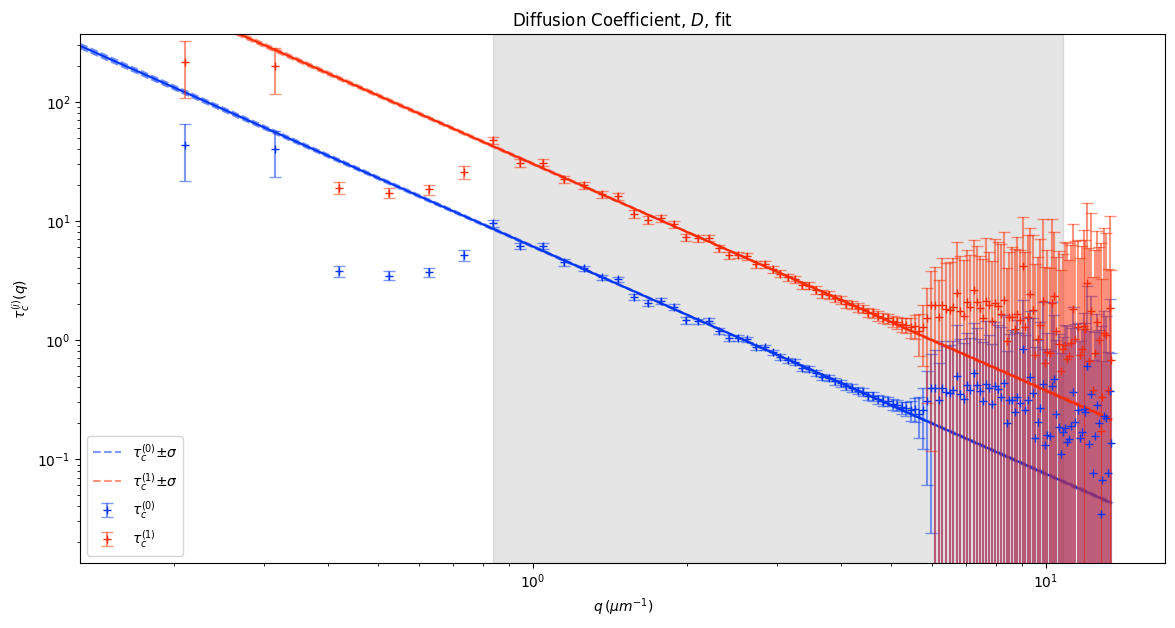

In [13]:
fit_result = min_result.fit_diffusion_coefficients(minimal_r_squared=0.97)
fig = fit_result.plot_diffusion_coeff_fit()

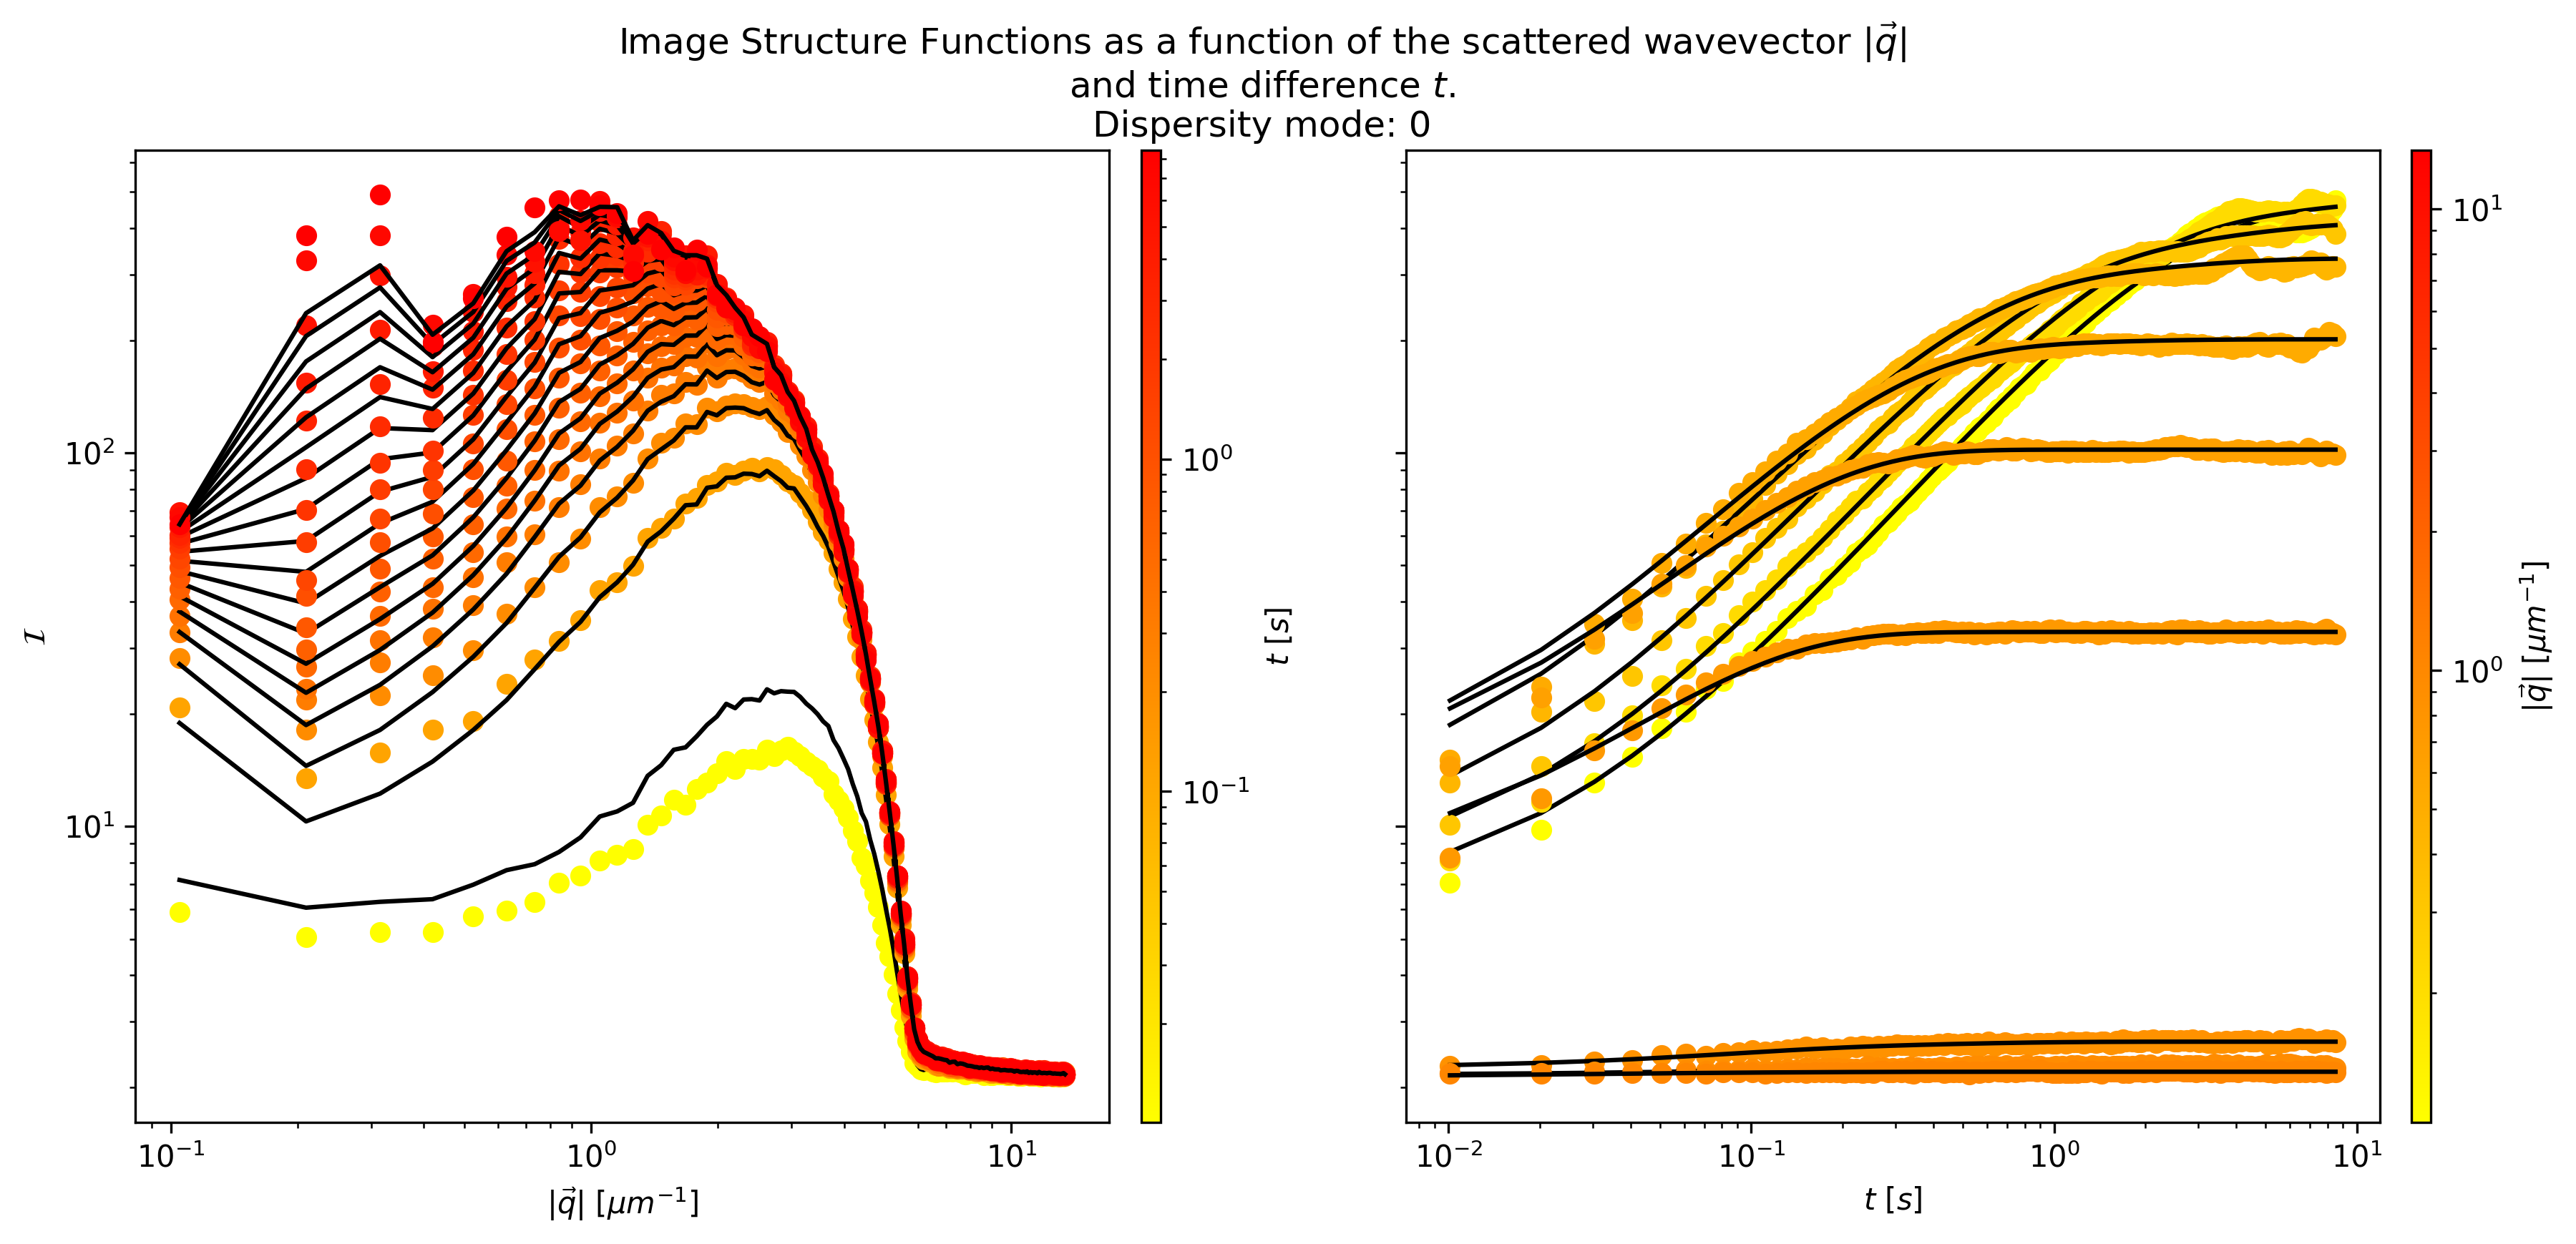

In [14]:
fig = fit_result.plot_image_structure_functions(q_interval=10)

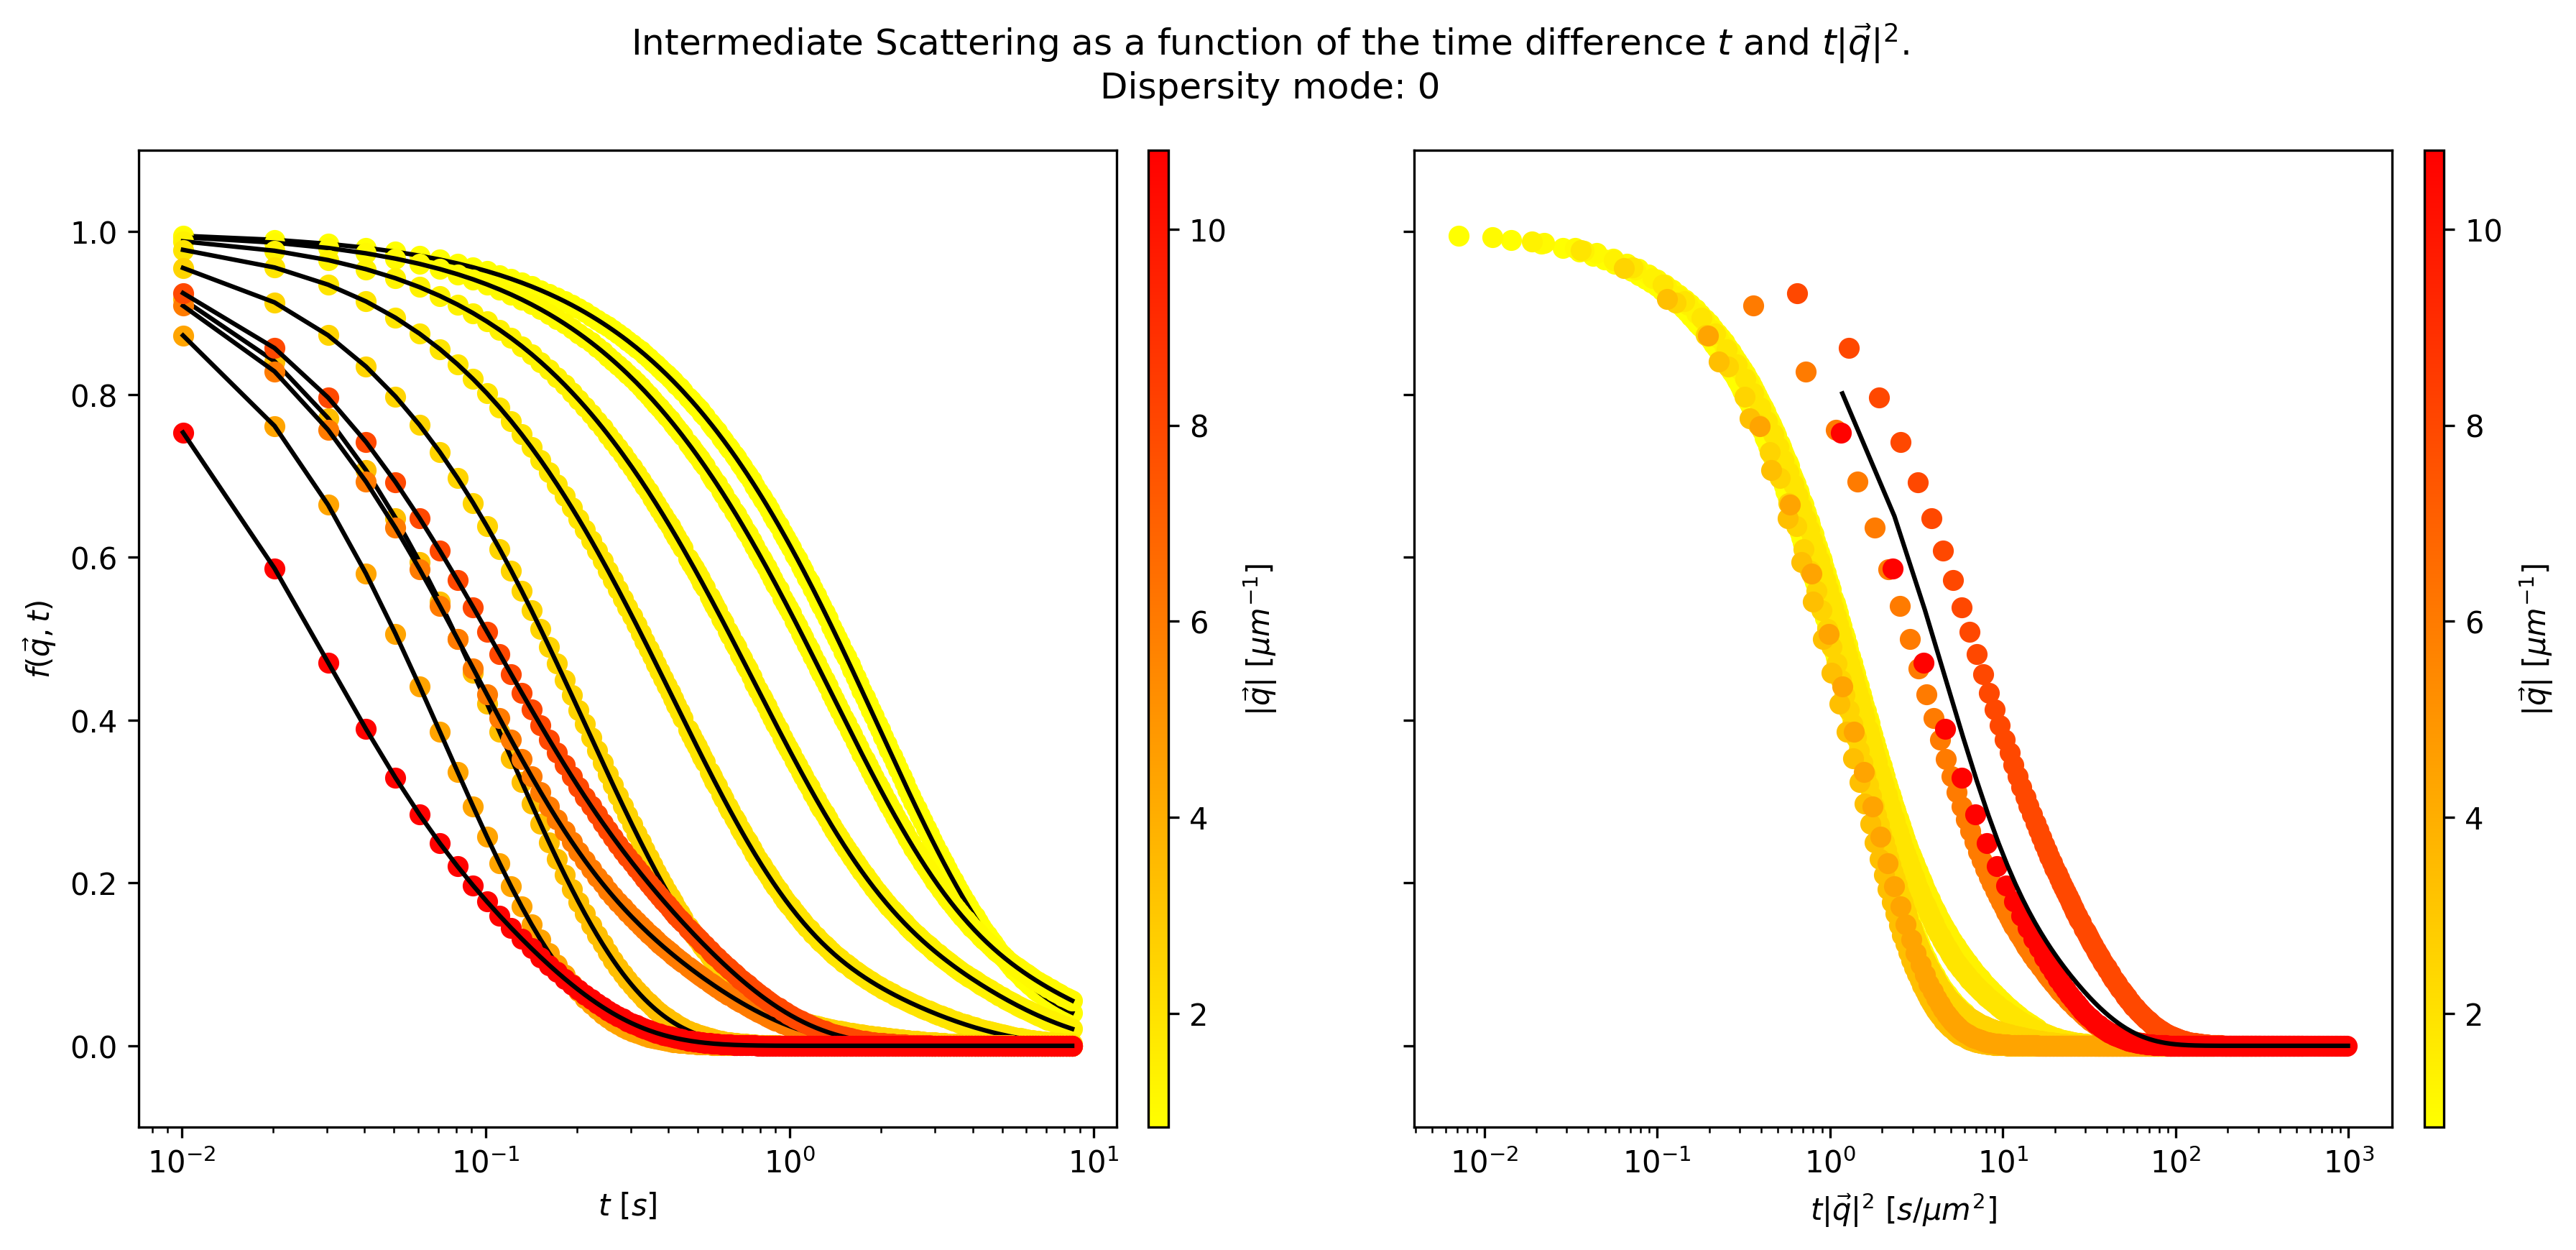

In [15]:
fig = fit_result.plot_intermediate_scattering_function(0)

In [16]:
print(fit_result.get_diffusion_coefficients())
print(fit_result.get_particle_diameters())

[0.16382428951573275+/-0.00232026891168797, 0.033136573390316865+/-0.000496511349657564]
[4.966339675445784e-07+/-7.033904183489679e-09, 2.455314432304734e-06+/-3.678990788388399e-08]
